# 第 9 章：循环神经网络 — PyTorch

## 导入 MNIST 数据集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor()])

# 训练集
trainset = torchvision.datasets.MNIST(root='./datasets/ch08/pytorch',     # 选择数据的根目录
                                      train=True,
                                      download=True,    # 不从网络上download图片
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.MNIST(root='./datasets/ch08/pytorch',     # 选择数据的根目录
                                     train=False,
                                     download=True,    # 不从网络上download图片
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [2]:
print(trainset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./datasets/ch08/pytorch
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
print(testset)

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./datasets/ch08/pytorch
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


接下来展示一些训练样本图像

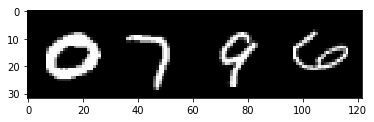

          0           7           9           6


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 选择一个 batch 的图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
plt.show()
# 打印 labels
print(' '.join('%11s' % labels[j].numpy() for j in range(4)))

## 定义循环神经网络

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(          # 使用 LSTM 结构
            input_size = 28,         # 输入每个元素的维度，即图片每行包含 28 个像素点
            hidden_size = 84,        # 隐藏层神经元设置为 84 个
            num_layers=2,            # 隐藏层数目，两层
            batch_first=True,        # 是否将 batch 放在维度的第一位，(batch, time_step, input_size)
        )
        self.out = nn.Linear(84, 10) # 输出层，包含 10 个神经元，对应 0～9 数字

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)   
        # 选择图片的最后一行作为 RNN 输出
        out = self.out(r_out[:, -1, :])
        return out

In [6]:
net = Net()
print(net) 

Net(
  (rnn): LSTM(28, 84, num_layers=2, batch_first=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


## 定义损失函数与优化算法

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

## 训练网络

In [8]:
num_epoches = 5    # 设置 epoch 数目
cost = []     # 损失函数累加

for epoch in range(num_epoches):    

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 输入样本和标签
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)  # 设置 RNN 输入维度为 (batch, time_step, input_size)

        # 每次训练梯度清零
        optimizer.zero_grad()

        # 正向传播、反向传播和优化过程
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印训练情况
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每隔2000 mini-batches，打印一次
            print('[epoch: %d, mini-batch: %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 2000))
            cost.append(running_loss / 2000)
            running_loss = 0.0

[epoch: 1, mini-batch:  2000] loss: 1.592
[epoch: 1, mini-batch:  4000] loss: 0.789
[epoch: 1, mini-batch:  6000] loss: 0.564
[epoch: 1, mini-batch:  8000] loss: 0.429
[epoch: 1, mini-batch: 10000] loss: 0.357
[epoch: 1, mini-batch: 12000] loss: 0.294
[epoch: 1, mini-batch: 14000] loss: 0.290
[epoch: 2, mini-batch:  2000] loss: 0.236
[epoch: 2, mini-batch:  4000] loss: 0.213
[epoch: 2, mini-batch:  6000] loss: 0.196
[epoch: 2, mini-batch:  8000] loss: 0.195
[epoch: 2, mini-batch: 10000] loss: 0.173
[epoch: 2, mini-batch: 12000] loss: 0.161
[epoch: 2, mini-batch: 14000] loss: 0.161
[epoch: 3, mini-batch:  2000] loss: 0.140
[epoch: 3, mini-batch:  4000] loss: 0.124
[epoch: 3, mini-batch:  6000] loss: 0.141
[epoch: 3, mini-batch:  8000] loss: 0.133
[epoch: 3, mini-batch: 10000] loss: 0.121
[epoch: 3, mini-batch: 12000] loss: 0.129
[epoch: 3, mini-batch: 14000] loss: 0.107
[epoch: 4, mini-batch:  2000] loss: 0.110
[epoch: 4, mini-batch:  4000] loss: 0.099
[epoch: 4, mini-batch:  6000] loss

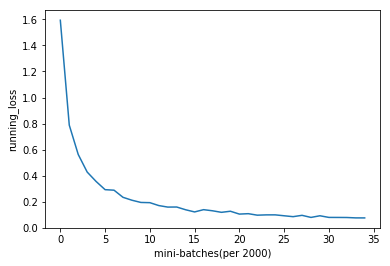

In [9]:
plt.plot(cost)
plt.xlabel('mini-batches(per 2000)')
plt.ylabel('running_loss')
plt.show()

## 测试数据

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.view(-1, 28, 28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60000 test images: %.3f %%' % 
     (100 * correct / total))

Accuracy of the network on the 60000 test images: 96.355 %


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 28, 28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % 
     (100 * correct / total))

Accuracy of the network on the 10000 test images: 95.790 %
